Followed this tutorial 

https://www.youtube.com/watch?v=2xrzJibPl3c

In [1]:
import keras,os
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D , Flatten
from keras.preprocessing.image import ImageDataGenerator
import numpy as np
from tqdm import tqdm
import random
import cv2

In [2]:
%cd ..
from google.colab import drive
drive.mount('./content/gdrive')

/
Mounted at ./content/gdrive


In [3]:
DATADIR = "/content/gdrive/MyDrive/Gait_analysis/all_fixed/data_150"

In [4]:
CATEGORIES = ["normal_resized150", "abnormal_resized150"]

In [5]:
# To make the training data and labels from the datadir and categories
c = 3
IMG_SIZE = 64
training_data = []
labels = []

def create_training_data():
    for category in CATEGORIES:
        path = os.path.join(DATADIR, category)
        class_num = CATEGORIES.index(category)
        for img in os.listdir(path):
            #try:
            img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
            new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
            #new_array = cv2.cvtColor(old_array, cv2.COLOR_RGB2BGR)
            training_data.append(new_array)
            
            if "abnormal_resized150" in category:
                labels.append(0)
            else:
                labels.append(1)
           # except Exception as e:
            #    pass

create_training_data()

In [6]:
type(training_data)

list

In [7]:
training_data = np.array(training_data)
labels = np.array(labels)

In [8]:
type(training_data)

numpy.ndarray

In [9]:
training_data.shape

(276, 64, 64)

In [10]:
training_data_flattened = training_data.reshape(len(training_data), 64, 64, 1)
training_data_flattened.shape

(276, 64, 64, 1)

In [11]:
training_data_reshaped = np.broadcast_to(training_data_flattened, (276, 64, 64, 3))
training_data_reshaped.shape

(276, 64, 64, 3)

In [12]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(training_data_reshaped, labels, random_state = 0)

In [13]:
X_train, X_test = X_train / 255.0, X_test / 255.0

In [14]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(207, 64, 64, 3)
(207,)
(69, 64, 64, 3)
(69,)


In [15]:
from tensorflow.keras.utils import to_categorical
train_labels = to_categorical(y_train)
test_labels = to_categorical(y_test)
print(train_labels.shape)
print(test_labels.shape)

(207, 2)
(69, 2)


In [16]:
# Final Split to be fed into the model

print(X_train.shape)
print(train_labels.shape)
print(X_test.shape)
print(test_labels.shape)

(207, 64, 64, 3)
(207, 2)
(69, 64, 64, 3)
(69, 2)


ResNet50

In [17]:
#from tensorflow.keras.applications.resnet50 import ResNet50
import tensorflow as tf
model = tf.keras.applications.ResNet50(weights = "imagenet", include_top = False, input_shape = (64, 64, 3))

94781440/94765736 [==============================] - 0s 0us/step


In [18]:
#model.summary()

In [19]:
X_test_ResNet_output = model.predict(X_test, verbose = 1)
X_train_ResNet_output = model.predict(X_train, verbose = 1) #Use this as feature extractor

7/7 [==============================] - 0s 66ms/step


In [20]:
print(X_test_ResNet_output.shape)
print(X_train_ResNet_output.shape)

(69, 2, 2, 2048)
(207, 2, 2, 2048)


In [21]:
import numpy as np
X_test_new = np.reshape(X_test_ResNet_output, (69, 2*2*2048))
X_train_new = np.reshape(X_train_ResNet_output, (207, 2*2*2048))

In [22]:
print(X_test_new.shape)
print(X_train_new.shape)

(69, 8192)
(207, 8192)


In [23]:
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers

new_model = models.Sequential()
new_model.add(layers.Dense(256, activation = "relu", input_dim = 2*2*2048))
new_model.add(layers.Dropout(0.3))
new_model.add(layers.BatchNormalization(momentum = 0.999, epsilon = 0.1))

new_model.add(layers.Dense(128, activation = "relu"))
new_model.add(layers.Dropout(0.6))
new_model.add(layers.BatchNormalization(momentum = 0.999, epsilon = 0.1))

new_model.add(layers.Dense(2, activation = "sigmoid"))

new_model.compile(optimizer = "rmsprop", loss = "categorical_crossentropy", metrics = ["accuracy"])
history = new_model.fit(X_train_new, train_labels, epochs = 10, batch_size = 10, validation_data = (X_test_new, test_labels))

Epoch 1/10
21/21 [==============================] - 3s 18ms/step - loss: 0.7751 - accuracy: 0.5990 - val_loss: 0.6558 - val_accuracy: 0.5362
Epoch 2/10
21/21 [==============================] - 0s 6ms/step - loss: 0.5977 - accuracy: 0.6715 - val_loss: 0.7000 - val_accuracy: 0.4783
Epoch 3/10
21/21 [==============================] - 0s 7ms/step - loss: 0.6151 - accuracy: 0.6618 - val_loss: 0.5618 - val_accuracy: 0.6232
Epoch 4/10
21/21 [==============================] - 0s 7ms/step - loss: 0.5322 - accuracy: 0.7391 - val_loss: 0.5465 - val_accuracy: 0.9565
Epoch 5/10
21/21 [==============================] - 0s 7ms/step - loss: 0.4529 - accuracy: 0.7874 - val_loss: 0.5540 - val_accuracy: 0.9275
Epoch 6/10
21/21 [==============================] - 0s 6ms/step - loss: 0.4618 - accuracy: 0.8116 - val_loss: 0.5530 - val_accuracy: 0.9420
Epoch 7/10
21/21 [==============================] - 0s 7ms/step - loss: 0.4122 - accuracy: 0.8261 - val_loss: 0.5775 - val_accuracy: 0.6087
Epoch 8/10
21/21 [=

Visualization

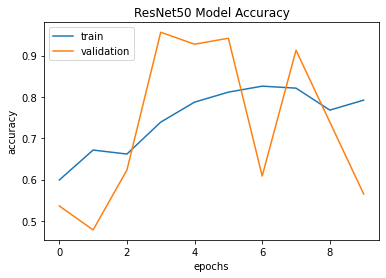

In [24]:
import matplotlib.pyplot as plt

plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.title("ResNet50 Model Accuracy")
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.legend(["train", "validation"], loc = "upper left")
plt.show()

In [25]:
predictions = new_model.predict(X_test_new)
y_pred = np.argmax(predictions, axis=1)

y_true = np.argmax(test_labels, axis=1)

In [26]:
test_loss, test_acc = new_model.evaluate(X_test_new , test_labels)
print('Test loss', test_loss)
print('Test accuracy', test_acc)

3/3 [==============================] - 0s 5ms/step - loss: 0.6698 - accuracy: 0.5652
Test loss 0.6698153614997864
Test accuracy 0.5652173757553101


In [27]:
# Classification report
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.17      0.29        36
           1       0.52      1.00      0.69        33

    accuracy                           0.57        69
   macro avg       0.76      0.58      0.49        69
weighted avg       0.77      0.57      0.48        69



In [28]:
# Let's view the confusion matrix
import sklearn
from sklearn.metrics import confusion_matrix

cm = sklearn.metrics.confusion_matrix(y_true, y_pred)
cm

array([[ 6, 30],
       [ 0, 33]])

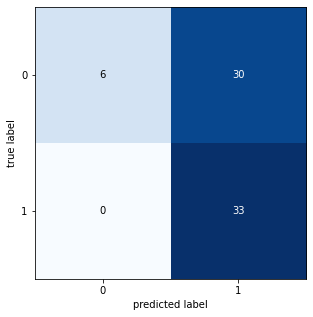

In [29]:
import matplotlib.pyplot as plt

CM = confusion_matrix(y_true,y_pred)
from mlxtend.plotting import plot_confusion_matrix
fig, ax = plot_confusion_matrix(conf_mat=CM, figsize=(5,5))
plt.show()

#Some Metrics

In [30]:
from sklearn.metrics import recall_score
recall_score(y_true, y_pred, pos_label=0)

0.16666666666666666

In [31]:
sensitivity = sklearn.metrics.recall_score(y_true , y_pred)
sensitivity

1.0

In [32]:
specificity = sklearn.metrics.recall_score(np.logical_not(y_true) , np.logical_not(y_pred))
specificity

0.16666666666666666

In [33]:
from sklearn.metrics import confusion_matrix

tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
specificity = tn / (tn+fp)
sensitivity = tp / (tp+fn)
precision = tp / (tp+fp)
recall = tp / (tp+fn)

In [34]:
print(specificity)
print(sensitivity)
print(precision)
print(recall)

0.16666666666666666
1.0
0.5238095238095238
1.0


NEEDs SOME brain storming

In [ ]:
# predict with the trained model 

labels = ["abnormal gait","normal gait"]
sample_image = X_test_new[32]
sample_label = test_labels[32]
predicted_label = y_pred[32]
model.predict([sample_image])
print("The true label says it is a", labels[predicted_label])
print("The model predicted it to be a", labels[sample_label])


# To see the predicted image, we need to change the 1D array to 2D array

example = np.reshape(sample_image, (64, 64))
plt.imshow(example, cmap = "gray")
plt.xlabel(labels[sample_label])
plt.show()

ValueError: ignored

In [ ]:
from keras.preprocessing import image
Img = image.load_img("", target_size = (64, 64))
Img = np.asarray(Img)
plt.imshow(Img)
Img = np.expand_dims(Img, axis=0)

FileNotFoundError: ignored